In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example
In this notebook we used public data from UNAM in Mexico. The objective is to make sure we obtained similar results given that they does not explain how the pressure correction was applied. 

The outcomes may vary because we don't know how much data they used. However, the plots are quite similar.
You can check UNAM's results here when a Forbush decrease was recorded https://www.sciesmex.unam.mx/blog/reporte-rayos-c%C3%B3smicos-2024-05-16/.

In [2]:
# Load data donwloaded from UNAM observatory (one month of data-taking i.e. May)
data = pd.read_csv('UNAM_data/1-5-2024_31-5-2024_min.txt',
                   sep='\s+',  # Use whitespace as the delimiter
                   names=['Date', 'Time', 'counts', 'pressure'],  # Assign column names
                   header=0)  # Skip the first row if it contains column headers

# Extract each column
print(data)

pressure = data['pressure']
date = data['Date']
time = data['Time']
fraction = (data['counts']-data['counts'].mean())/data['counts'].mean()
counts = data['counts']
df_selected = pd.DataFrame({
    'counts': counts,
    'fraction': fraction,
    'pressure': pressure
})
print(df_selected)

             Date      Time  counts  pressure
0      2024-05-01  00:00:00   14020     771.7
1      2024-05-01  00:01:00   13983     771.7
2      2024-05-01  00:02:00   13569     771.7
3      2024-05-01  00:03:00   13941     771.7
4      2024-05-01  00:04:00   14111     771.7
...           ...       ...     ...       ...
44621  2024-05-31  23:55:00   13521     772.9
44622  2024-05-31  23:56:00   13714     772.9
44623  2024-05-31  23:57:00   13449     772.9
44624  2024-05-31  23:58:00   13507     772.9
44625  2024-05-31  23:59:00   13560     773.0

[44626 rows x 4 columns]
       counts  fraction  pressure
0       14020  0.047185     771.7
1       13983  0.044422     771.7
2       13569  0.013499     771.7
3       13941  0.041285     771.7
4       14111  0.053982     771.7
...       ...       ...       ...
44621   13521  0.009914     772.9
44622   13714  0.024329     772.9
44623   13449  0.004536     772.9
44624   13507  0.008868     772.9
44625   13560  0.012827     773.0

[44626 rows x

<IPython.core.display.Javascript object>


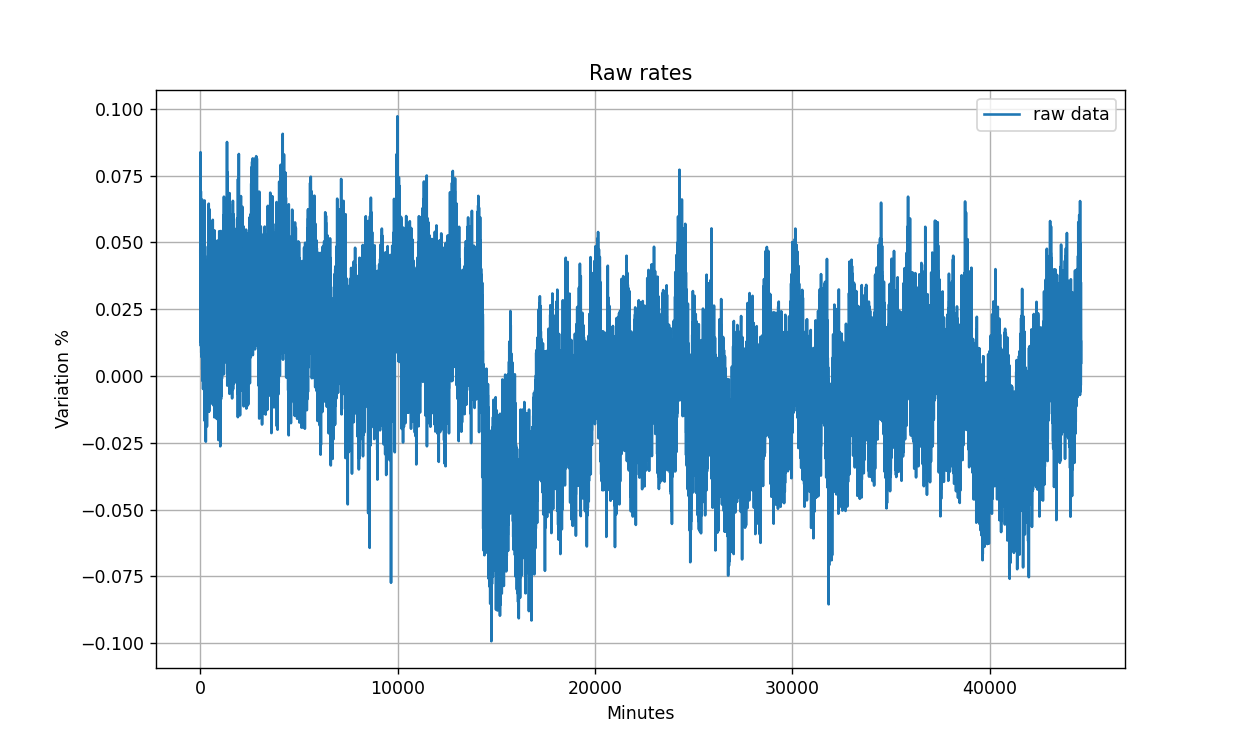

In [3]:
# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(fraction, '-', label='raw data')  # Plot with markers for better visibility
plt.xlabel('Minutes')  # Label for the x-axis
plt.ylabel('Variation %')  # Label for the y-axis
plt.title('Raw rates')  # Title of the plot
plt.grid(True)  # Add gridlines
plt.legend()  # Show legend
plt.show()  # Display the plot

### Correlation matrix
One expects a negative correlation coefficient for pressure and counts, this is the higher the counts the lower the pressure and vice versa

Matriz de correlación:
            counts  fraction  pressure
counts    1.000000  1.000000 -0.499189
fraction  1.000000  1.000000 -0.499189
pressure -0.499189 -0.499189  1.000000


<IPython.core.display.Javascript object>


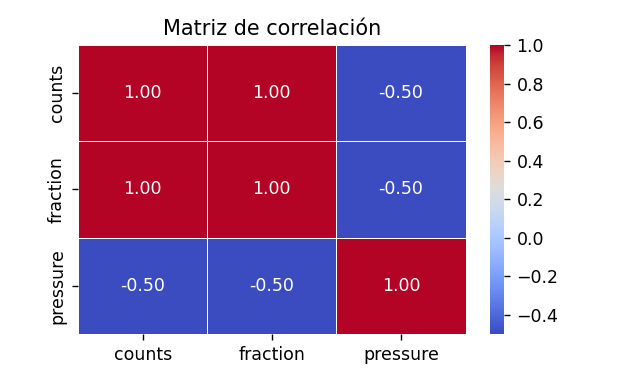

In [9]:
correlation_matrix = df_selected.corr()

# Matriz de correlación
print("Matriz de correlación:")
print(correlation_matrix)

#plot
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Matriz de correlación")
plt.show()

### Applying pressure correction 
The equation that describes the dependence of counts on pressure is $N=N_oe^{-\beta (P-P_o)}$ (1), where $N_o$ is the mean value for the counts, $P_o$ is the reference value for pressure (its mean value). Finally, $\beta$ is the barometric coefficient.
For computing $\beta$, we use $\beta = r \dfrac{\sigma_{count variation}}{\sigma_{pressure}}$ where $r$ is the correlation coefficient of pressure and count variation, and $\sigma$ are their corresponding standard deviations.

This way for computing $\beta$ just can be applied when using the variation of rates (count variation). Taking equation (1) and using a Taylor expansion:
$N\approx N_o(1-\beta(P-P_o))$ valid for small variations of pressure.

Thus,
$\dfrac{N-N_o}{N_o}=-\beta(P-P_o)$

So, one must use $\dfrac{N-N_o}{N_o}$ (count variation) which was coded above as: 

```python
fraction = (data['counts']-data['counts'].mean())/data['counts'].mean()
```

Finally, once the $\beta$ is computed, the correction must be applied as follows:

$N_{corrected}=N_{raw}(1-\beta(P-P_o))$

$\beta$ is expected to be negative which indicates a inverse relation between rates and pressure, i.e. the higher the rates the lower the pressure and viceversa

### References:
https://doi.org/10.1016/j.newast.2012.08.003

https://arxiv.org/pdf/2004.11013

In [10]:
## lets apply pressure correction

results = {}
P_ref= df_selected['pressure'].mean()
print(f'Mean pressure: {P_ref}')

for col in df_selected.columns[:1]:
    # Computing beta
    beta_final = correlation_matrix.loc['fraction', 'pressure'] * (df_selected['fraction'].std()) / (df_selected['pressure'].std())

    # Applying the correction to rates
    correccion_data_pt = df_selected[col] * (1 -beta_final * (df_selected['pressure'] - P_ref))

    results[col] = correccion_data_pt
results_df = pd.DataFrame(results)
print(f'β = {(beta_final):.4f} /hPa.')
display(results_df)

Mean pressure: 774.6440169407969
β = -0.0068 /hPa.


,counts
0,13738.277103
1,13702.020595
2,13296.339659
3,13660.864558
4,13827.448517
...,...
44621,13360.049126
44622,13550.751699
44623,13288.906198
44624,13346.215779


<IPython.core.display.Javascript object>


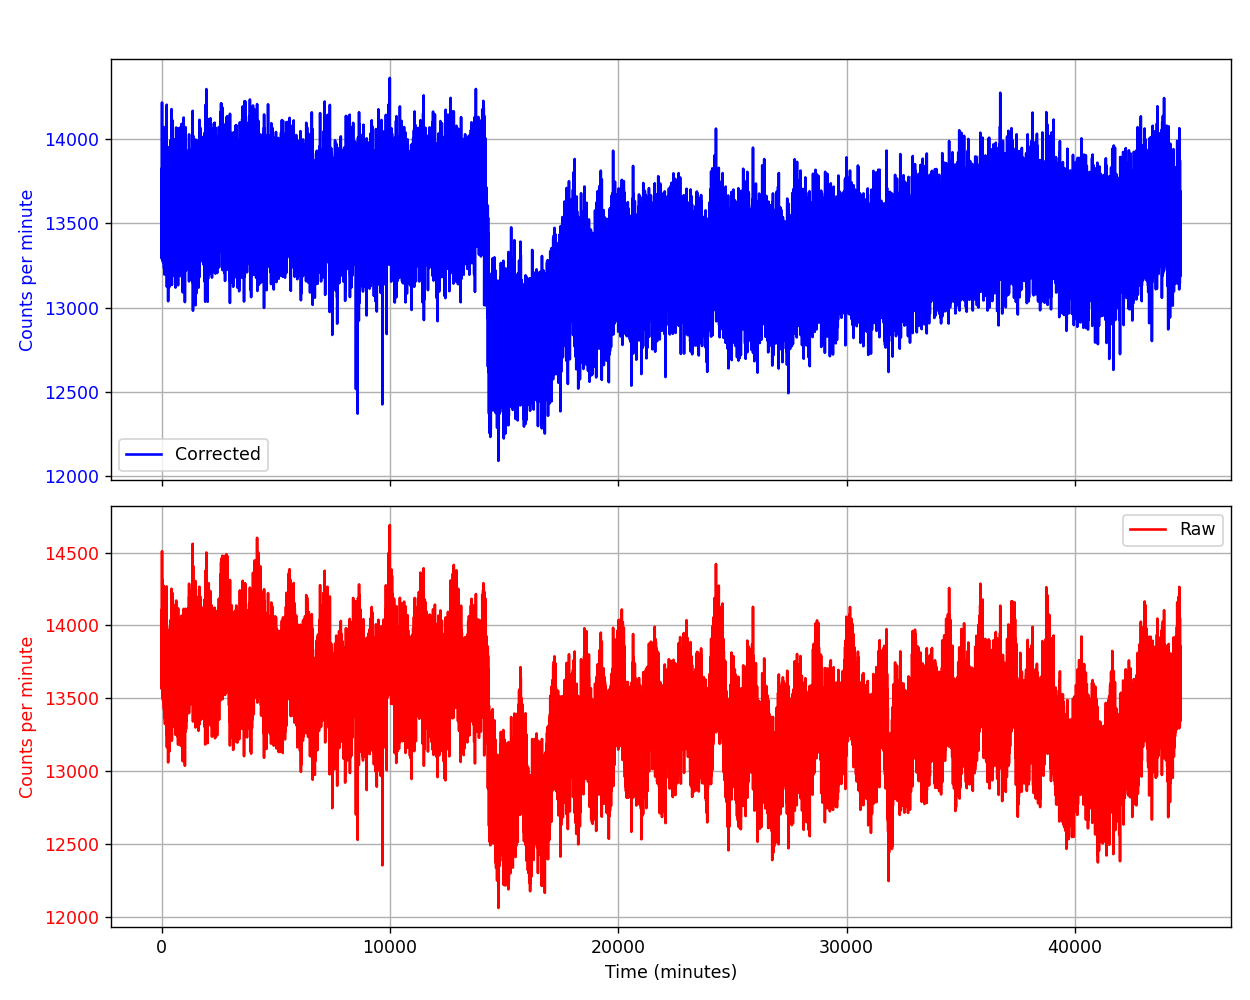

In [11]:
# Create subplots: 2 rows, 1 column, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


# Plot counts in the upper subplot
ax1.plot(results_df['counts'], '-', color='blue', label='Corrected')
ax1.set_ylabel('Counts per minute', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
ax1.legend()
# Plot pressure in the lower subplot
ax2.plot(df_selected['counts'], '-', color='red', label='Raw')
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Counts per minute', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(True)

# Add a title to the figure
plt.legend()
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

### Plotting per-hour rates after applying the pressure correction to per-minute data

<IPython.core.display.Javascript object>


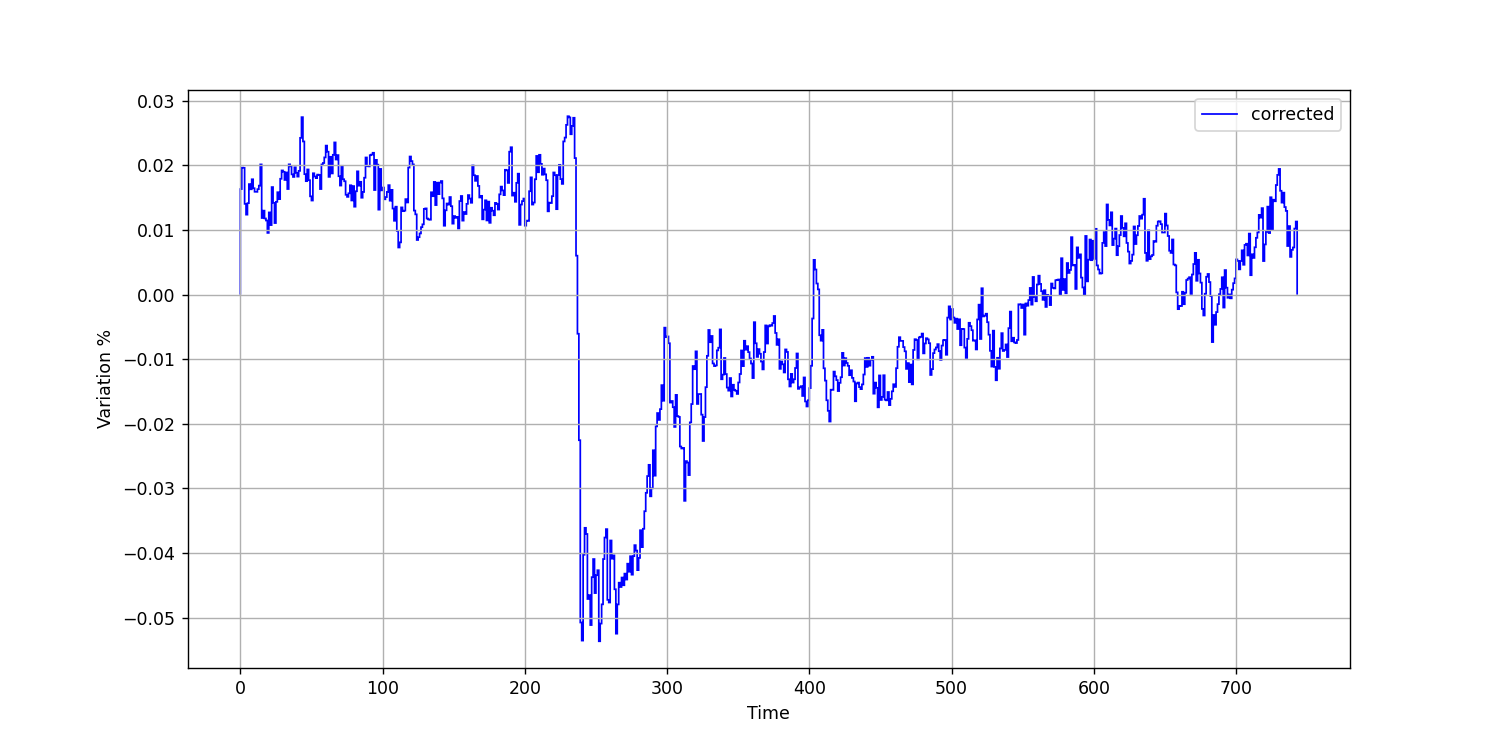

In [13]:
hour = (np.array(results_df['counts'][:44580]).reshape(-1,60)).sum(axis =1) #44580 is just a multiple of 60

hour_f = (hour - hour.mean())/hour.mean()

# Create the plot
plt.figure(figsize=(12, 6))  # Set the figure size
#plt.plot(hour_f, '-', label='corrected')  # Plot with markers for better visibility
plt.stairs(hour_f, range(len(hour_f) + 1), color='blue', label='corrected')

plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Variation %')  # Label for the y-axis
plt.grid(True)  # Add gridlines
plt.legend()  # Show legend
plt.show()  # Display the plot

### 1 hour granularity

We do the same as above but applied to per-hour data, this is rates per hour. The rates used above are per-minute data.

In [15]:
counts_hour = (np.array(df_selected['counts'][:44580]).reshape(-1,60)).sum(axis =1)
pressure_hour = (np.array(df_selected['pressure'][:44580]).reshape(-1,60)).mean(axis =1)

fraction_hour = (counts_hour-counts_hour.mean())/counts_hour.mean()

# Combine the processed arrays into a DataFrame
hour_df = pd.DataFrame({
    'counts': counts_hour,
    'fraction': fraction_hour,
    'pressure': pressure_hour
})
print(hour_df)

     counts  fraction    pressure
0    831520  0.035154  771.961667
1    830805  0.034264  772.555000
2    826329  0.028692  773.333333
3    818315  0.018716  773.953333
4    814349  0.013778  774.421667
..      ...       ...         ...
738  805410  0.002650  775.090000
739  810512  0.009002  774.323333
740  814726  0.014248  773.620000
741  820942  0.021986  772.938333
742  824289  0.026153  772.505000

[743 rows x 3 columns]


Matriz de correlación:
            counts  fraction  pressure
counts    1.000000  1.000000 -0.596185
fraction  1.000000  1.000000 -0.596185
pressure -0.596185 -0.596185  1.000000


<IPython.core.display.Javascript object>


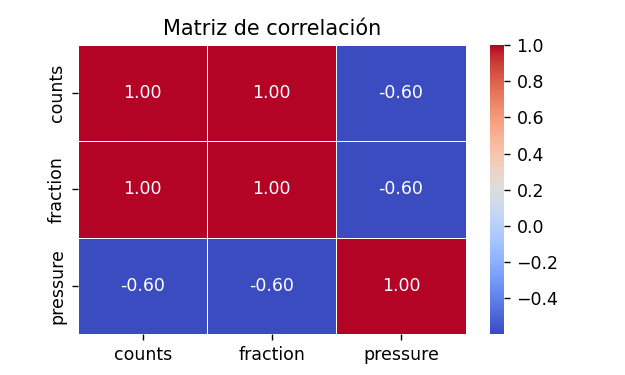

In [16]:
correlation_matrix_hour = hour_df.corr()

# Matriz de correlación
print("Matriz de correlación:")
print(correlation_matrix_hour)

#plot
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix_hour, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Matriz de correlación")
plt.show()

In [17]:
## lets apply pressure correction

results_hour = {}
P_ref= hour_df ['pressure'].mean()

# Calculos de los coeficientes de correccion alpha, beta.

beta_final = correlation_matrix.loc['fraction', 'pressure'] * (hour_df ['fraction'].std()) / (hour_df ['pressure'].std())

# Corrección por presión y temperatura.
correccion_data_pt = hour_df ['counts'] * (1 - ((beta_final) * (hour_df ['pressure'] - P_ref)))

results_hour['counts'] = correccion_data_pt
results_hour_df = pd.DataFrame(results_hour)
print(f'β = {(beta_final):.4f} /hPa')
display(results_hour_df)

β = -0.0057 /hPa


,counts
0,818772.341910
1,820883.634911
2,820134.335471
3,815078.049873
4,813305.935880
...,...
738,807452.654376
739,809018.661351
740,809952.210059
741,812935.718405


<IPython.core.display.Javascript object>


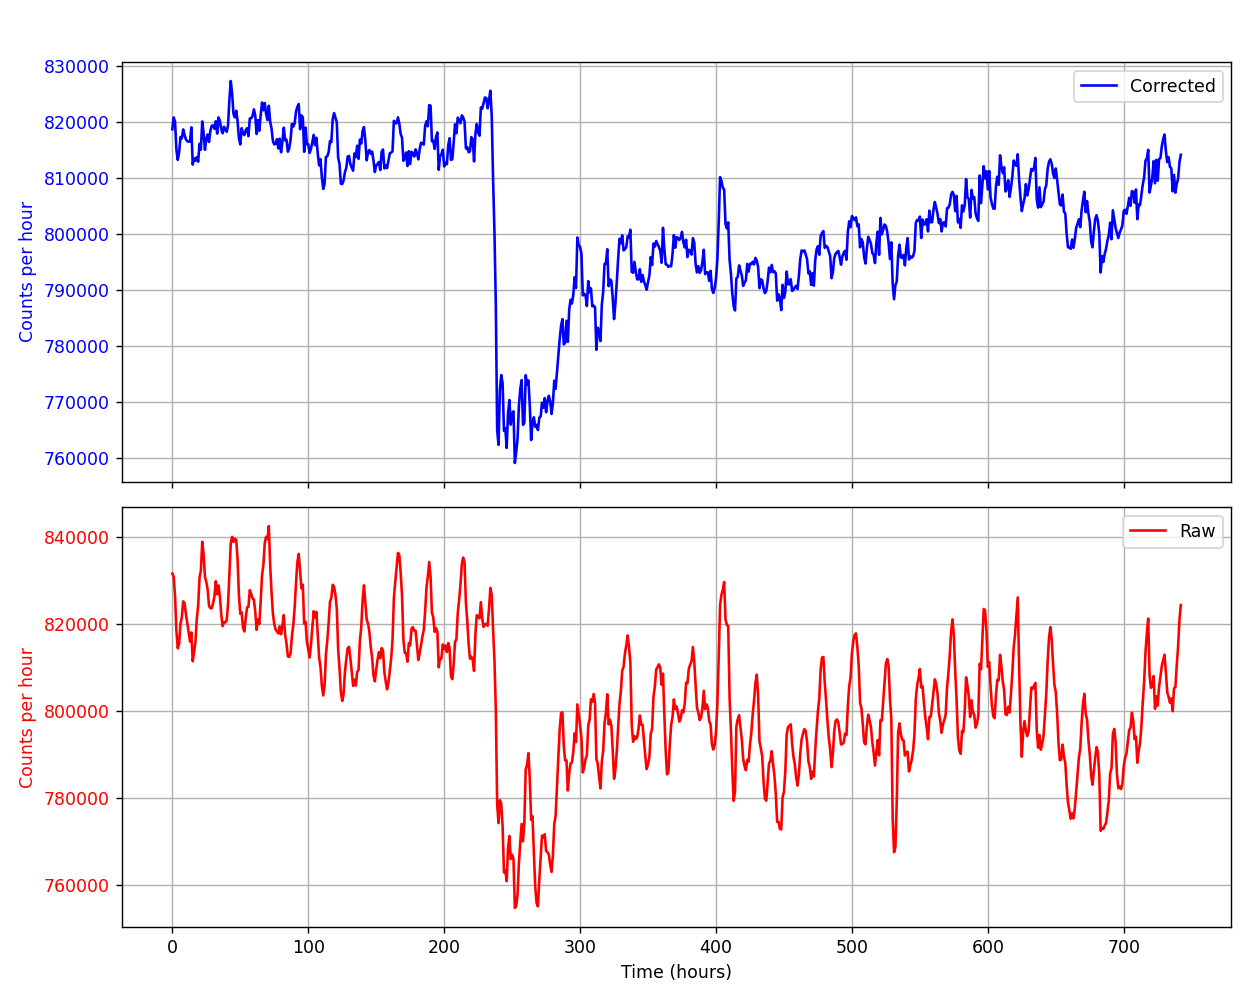

In [18]:
# Create subplots: 2 rows, 1 column, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


# Plot counts in the upper subplot
ax1.plot(results_hour_df['counts'], '-', color='blue', label='Corrected')
ax1.set_ylabel('Counts per hour', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
ax1.legend()
# Plot pressure in the lower subplot
ax2.plot(hour_df['counts'] , '-', color='red', label='Raw')
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Counts per hour', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.legend()

# Show the plot
plt.show()

<IPython.core.display.Javascript object>


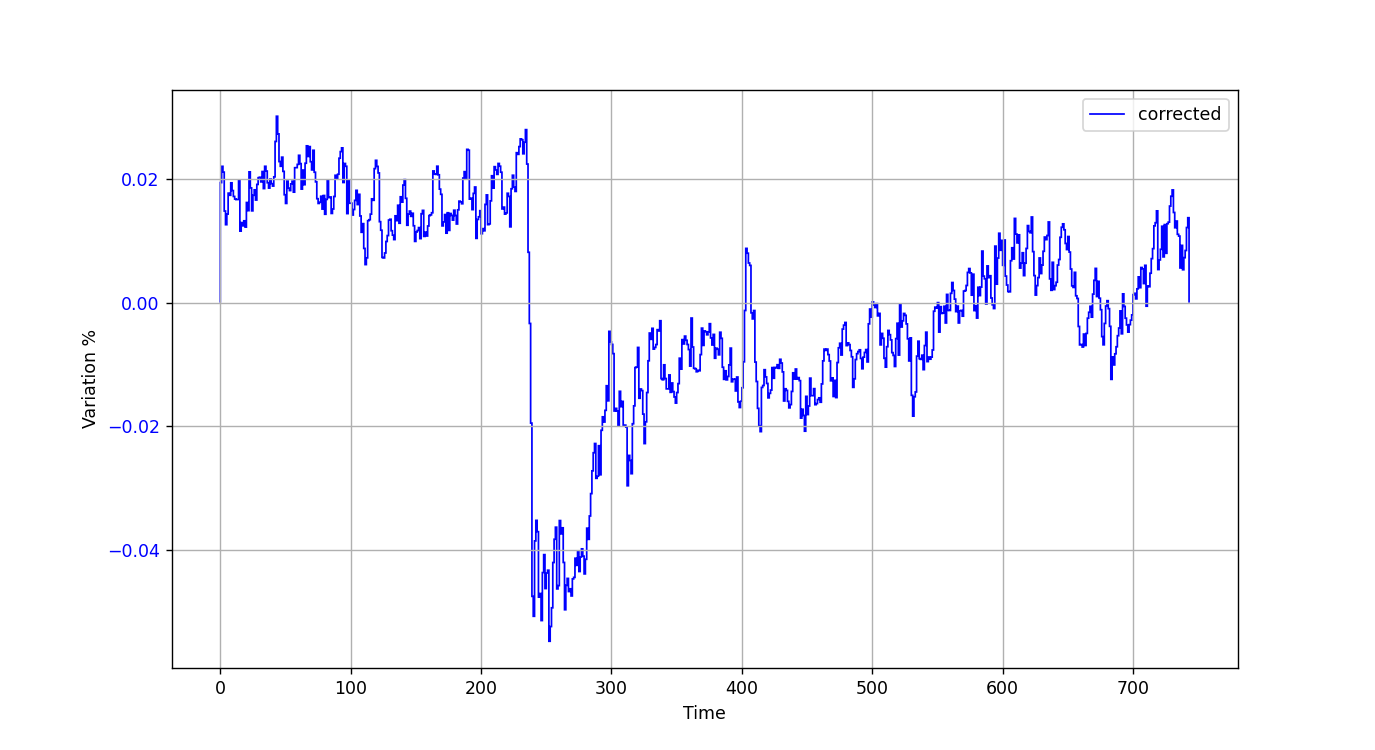

In [20]:
# Create a figure and a single subplot
fig = plt.subplots(figsize=(11, 6))

fraccion = (results_hour_df['counts']-results_hour_df['counts'].mean())/results_hour_df['counts'].mean()

# Plot counts on the primary y-axis (left)
plt.stairs(fraccion, range(len(fraccion) + 1), color='blue', label = 'corrected')
#plt.plot(fraccion)
plt.tick_params(axis='y', labelcolor='blue')


# Add a grid for better readability
plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Variation %')  # Label for the y-axis
plt.grid(True)  # Add gridlines
plt.legend()  # Show legend


# Show the plot
plt.show()

You can notice that the barometric coefficient β slighly varies depending on the use of per-minute or per-hour data. 